In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install bertviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 7.1 MB/s eta 0:00:00


In [3]:
from transformers import AutoTokenizer
from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)
text = "time flies like an arrow"
show(model, "bert", tokenizer, text, display_mode="light", layer=0, head=8)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

100%|██████████| 440473133/440473133 [00:15<00:00, 28458765.88B/s]
/usr/local/lib/python3.10/dist-packages/bertviz/transformers_neuron_view/modeling_utils.py:482: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues rela

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
inputs = tokenizer(text, return_tensors="pt", add_special_tokens=False)
inputs.input_ids

tensor([[ 2051, 10029,  2066,  2019,  8612]])

In [5]:
from torch import nn
from transformers import AutoConfig

config = AutoConfig.from_pretrained(model_ckpt)
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)
token_emb

Embedding(30522, 768)

In [6]:
inputs_embeds = token_emb(inputs.input_ids)
inputs_embeds.size()

torch.Size([1, 5, 768])

In [7]:
inputs_embeds

tensor([[[-0.3541, -0.6565,  1.1967,  ..., -0.3722, -0.4365, -0.1669],
         [ 1.8131, -0.1019, -0.6271,  ..., -1.2197,  1.2570,  1.3354],
         [-1.4147,  1.1554, -0.1048,  ..., -0.1551, -0.6773,  0.2003],
         [ 1.0992, -0.0027,  0.2508,  ...,  0.7857, -0.3183,  0.8643],
         [ 1.4034, -0.3838,  1.9470,  ..., -0.7975,  0.5196,  0.1899]]],
       grad_fn=<EmbeddingBackward0>)

In [8]:
inputs.input_ids

tensor([[ 2051, 10029,  2066,  2019,  8612]])

In [9]:
import torch 
from math import sqrt

query = key = value = inputs_embeds
dim_k = key.size(-1)
scores = torch.bmm(query, key.transpose(1,2)) / sqrt(dim_k)
scores.size()

torch.Size([1, 5, 5])

In [10]:
import torch.nn.functional as F

weights = F.softmax(scores, dim=-1)
weights.sum(dim=-1)

tensor([[1., 1., 1., 1., 1.]], grad_fn=<SumBackward1>)

In [11]:
weights

tensor([[[1.0000e+00, 3.8191e-11, 6.5493e-11, 4.0281e-11, 2.8983e-10],
         [3.2071e-12, 1.0000e+00, 4.1654e-12, 2.0416e-12, 4.0289e-13],
         [2.3695e-12, 1.7946e-12, 1.0000e+00, 3.3283e-12, 5.1038e-12],
         [3.5079e-13, 2.1172e-13, 8.0114e-13, 1.0000e+00, 8.6276e-13],
         [2.6349e-12, 4.3617e-14, 1.2825e-12, 9.0067e-13, 1.0000e+00]]],
       grad_fn=<SoftmaxBackward0>)

In [12]:
attn_outputs = torch.bmm(weights, value)
attn_outputs.shape

torch.Size([1, 5, 768])

In [13]:
def scaled_dot_product_attention(query, key, value):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1,2)) / sqrt(dim_k)
    weights = F.softmax(scores, dim=-1)
    return torch.bmm(weights, value)

In [14]:
class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(
            self.q(hidden_state), self.k(hidden_state), self.v(hidden_state)
        )
        return attn_outputs

In [15]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
        x = self.output_linear(x)
        return x

In [16]:
multihead_attn = MultiHeadAttention(config)
attn_output = multihead_attn(inputs_embeds)
attn_output.size()

torch.Size([1, 5, 768])

In [17]:
attn_output

tensor([[[ 0.2782,  0.1372,  0.0776,  ...,  0.0687, -0.1225,  0.1928],
         [ 0.3253,  0.2463, -0.0316,  ...,  0.0492, -0.1717,  0.2626],
         [ 0.3502,  0.1801,  0.0370,  ...,  0.0503, -0.1951,  0.1596],
         [ 0.2229,  0.1781,  0.0756,  ...,  0.0615, -0.1653,  0.2019],
         [ 0.3184,  0.1246,  0.0553,  ...,  0.0158, -0.1385,  0.2065]]],
       grad_fn=<ViewBackward0>)

In [18]:
from bertviz import head_view
from transformers import AutoModel

model = AutoModel.from_pretrained(model_ckpt, output_attentions=True)

sentence_a = "time flies like an arrow"
sentence_b = "fruit flies like a banana"

viz_inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt')
attention = model(**viz_inputs).attentions
sentence_b_start = (viz_inputs.token_type_ids == 0).sum(dim=1)
tokens = tokenizer.convert_ids_to_tokens(viz_inputs.input_ids[0])

head_view(attention, tokens, sentence_b_start, heads=[8])

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


<IPython.core.display.Javascript object>

#### the feed-forward sublayer in the encoder and decoder is just a simple two-layer fully connected neural network, but with a twist: instead of processing the whole sequence of embeddings as a single vector, it processes each embedding independently

In [19]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear_1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.dropout = nn. Dropout(config.hidden_dropout_prob)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        return x

In [20]:
feed_forward = FeedForward(config)
ff_outputs = feed_forward(attn_outputs)
ff_outputs.size()

torch.Size([1, 5, 768])

#### layer normalization: normalizes each input in the batch to have zero mean and unity variance.
#### post layer normalization: 将ln放在两个残差连接之间,这种方式梯度扩散,需要学习率预热
#### pre layer normalization: 将ln放在残差连接之内,训练时更稳定,通常不需要学习率预热
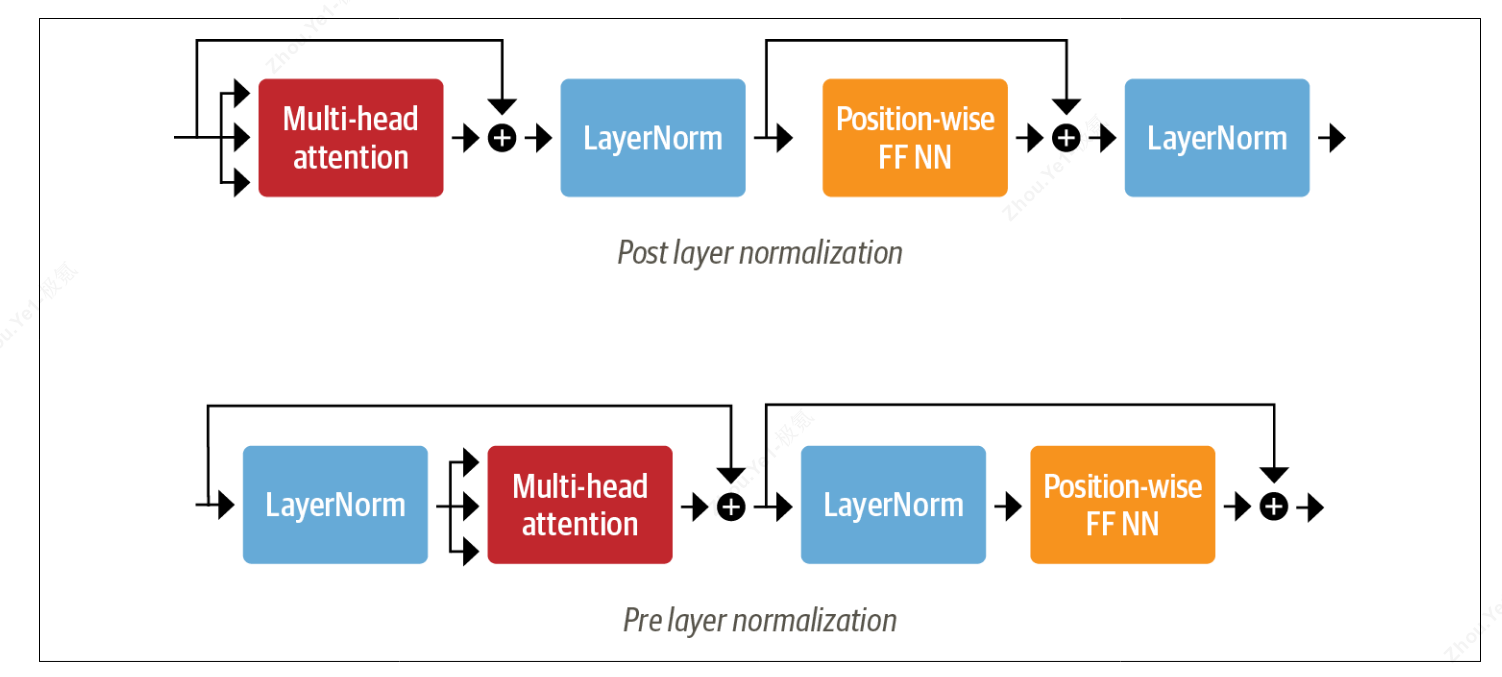
#### skip connections: pass a tensor to the next layer of the model without processing and add it to the processed tensor(resnet).

In [21]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
        self.attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)

    def forward(self, x):
        # Apply layer normalization and then copy input into query, key, value
        hidden_state = self.layer_norm_1(x)
        # Apply attention with a skip connection
        x = x + self.attention(hidden_state)
        # Apply feed-forward layer with a skip connection
        x = x + self.feed_forward(self.layer_norm_2(x))
        return x

In [22]:
encoder_layer = TransformerEncoderLayer(config)
inputs_embeds.shape, encoder_layer(inputs_embeds).size()

(torch.Size([1, 5, 768]), torch.Size([1, 5, 768]))

In [23]:
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embeddings = nn.Embedding(config.vocab_size,
                                            config.hidden_size)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings,
                                               config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout()

    def forward(self, input_ids):
        # Create position IDs for input sequence
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0)
        # Create token and position embeddings
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        # Combine token and position embeddings
        embeddings = token_embeddings + position_embeddings
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

embedding_layer = Embeddings(config)
embedding_layer(inputs.input_ids).size()

torch.Size([1, 5, 768])

In [24]:
class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = Embeddings(config)
        self.layers = nn.ModuleList([TransformerEncoderLayer(config)
                                   for _ in range(config.num_hidden_layers)])

    def forward(self, x):
        x = self.embeddings(x)
        for layer in self.layers:
            x = layer(x)
        return x

In [25]:
encoder = TransformerEncoder(config)
encoder(inputs.input_ids).size()

torch.Size([1, 5, 768])

In [26]:
class TransformerForSequenceClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = TransformerEncoder(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, x):
        x = self.encoder(x)[:, 0, :] # select hidden state of [CLS] token
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [27]:
config.num_labels = 3
encoder_classifier = TransformerForSequenceClassification(config)
encoder_classifier(inputs.input_ids).size()

torch.Size([1, 3])

In [28]:
seq_len = inputs.input_ids.size(-1)
mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)
mask[0]

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])

In [29]:
scores.masked_fill(mask == 0, -float("inf"))

tensor([[[ 2.4425e+01,        -inf,        -inf,        -inf,        -inf],
         [ 4.3621e-01,  2.6902e+01,        -inf,        -inf,        -inf],
         [ 9.7556e-01,  6.9764e-01,  2.7744e+01,        -inf,        -inf],
         [ 4.8950e-01, -1.5405e-02,  1.3154e+00,  2.9168e+01,        -inf],
         [ 2.4629e+00, -1.6382e+00,  1.7429e+00,  1.3894e+00,  2.9125e+01]]],
       grad_fn=<MaskedFillBackward0>)

In [30]:
def scaled_dot_product_attention(query, key, value, mask=None):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1,2)) / sqrt(dim_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -float("inf"))
    weights = F.softmax(scores, dim=-1)
    return weight.bmm(value)

In [31]:
class EncoderDecoderAttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def forward(self, encoder_hidden_state, decoder_hidden_state):
        attn_outputs = scaled_dot_product_attention(
            self.q(decoder_hidden_state), self.k(encoder_hidden_state), self.v(encoder_hidden_state), mask=None
        )
        return attn_outputs